In [ ]:
! pip3 install transformers

  Using cached transformers-4.34.1-py3-none-any.whl (7.7 MB)
  Using cached huggingface_hub-0.18.0-py3-none-any.whl (301 kB)
  Using cached tokenizers-0.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.8 MB)
  Using cached safetensors-0.4.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached huggingface_hub-0.17.3-py3-none-any.whl (295 kB)


In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)

from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)

project_dir = './'

In [ ]:
! nvidia-smi

Wed Oct 25 06:28:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data

In [ ]:
df = pd.read_csv(project_dir + 'full_data.csv')
print(df.shape)
df.head()

(1808, 16)


,ID,Text,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,CVE-2020-5421,"In Spring Framework versions 5.2.0 - 5.2.8, 5....",0,0,0,1,0,1,0,1,0,0,1,0,0,0
1,CVE-2020-5413,Spring Integration framework provides Kryo Cod...,0,0,1,1,0,1,0,0,0,0,0,0,0,0
2,CVE-2020-28035,WordPress before 5.5.2 allows attackers to gai...,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,CVE-2017-13715,The __skb_flow_dissect function in net/core/fl...,0,0,0,1,0,0,1,0,0,0,0,0,0,1
4,CVE-2014-2523,net/netfilter/nf_conntrack_proto_dccp.c in the...,0,0,0,1,0,0,1,0,0,0,0,0,0,1


In [ ]:
tactics = df.columns[2:]
df_filtered = df.drop(df[(df[tactics] == 0).all(axis=1)].index)

df = df_filtered
print(df.shape)

(1718, 16)


In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

final_texts = []
final_labels = []

def clean_abstract(text):
    # Replace versions with the word "VERSION"
    version_pattern = r"\d+(\.\d+)+"
    updated_text = re.sub(version_pattern, "version", text)

    # Replace other CVE references
    version_pattern = r'CVE-\d{1,5}-\d{1,5}'
    updated_text = re.sub(version_pattern, "CVE", updated_text)

    return updated_text

def get_texts(df):
    texts = df['Text'].apply(clean_abstract)
    texts = texts.values.tolist()
    return texts

def get_labels(df):
    labels = df.iloc[:, 2:].values
    return labels

def get_ids(df):
    ids = df['ID'].values.tolist()
    return ids

texts = get_texts(df)
labels = get_labels(df)
ids = get_ids(df)

for text, label, id in zip(texts[:5], labels[:5], ids):
    print(f'Text -\t{text}')
    print(f'ID -\t{id}')
    print(f'Labels -\t{label}')
    print()

Text -	In Spring Framework versions version - version, version - version, version - version, version - version, and older unsupported versions, the protections against RFD attacks from CVE may be bypassed depending on the browser used through the use of a jsessionid path parameter
ID -	CVE-2020-5421
Labels -	[0 0 0 1 0 1 0 1 0 0 1 0 0 0]

Text -	Spring Integration framework provides Kryo Codec implementations as an alternative for Java (de)serialization. When Kryo is configured with default options, all unregistered classes are resolved on demand. This leads to the "deserialization gadgets" exploit when provided data contains malicious code for execution during deserialization. In order to protect against this type of attack, Kryo can be configured to require a set of trusted classes for (de)serialization. Spring Integration should be proactive against blocking unknown "deserialization gadgets" when configuring Kryo in code
ID -	CVE-2020-5413
Labels -	[0 0 1 1 0 1 0 0 0 0 0 0 0 0]

Tex

## Exploratory Data Analysis

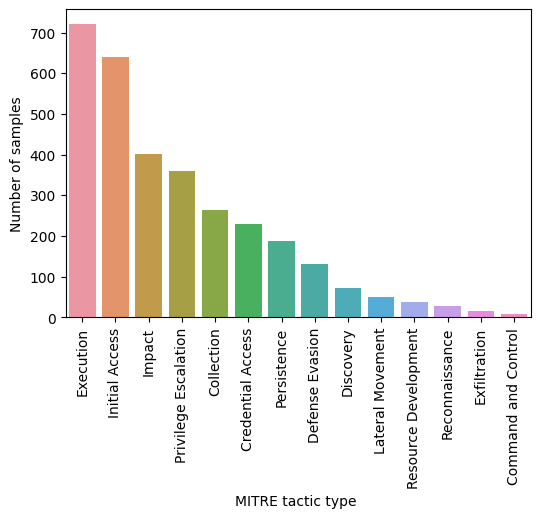

In [ ]:
categories = df.iloc[:, 2:].sum()
plt.figure(figsize=(6, 4))

sorted_categories = categories.sort_values(ascending=False).index
ax = sns.barplot(x=sorted_categories, y=categories[sorted_categories].values)

plt.ylabel('Number of samples')
plt.xlabel('MITRE tactic type ')
plt.xticks(rotation=90)
plt.show()

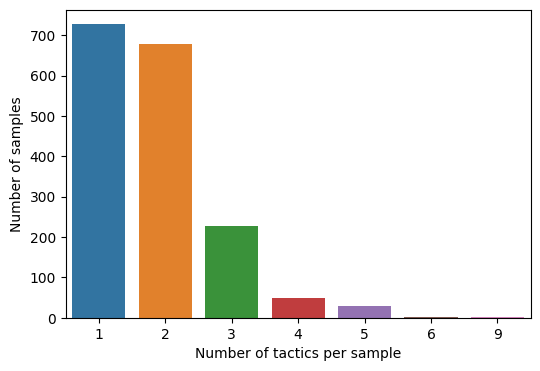

In [ ]:
row_sums = df.iloc[:, 2:].sum(axis=1)
multilabel_counts = row_sums.value_counts()

sorted_counts = multilabel_counts.sort_index()
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=sorted_counts.index, y=sorted_counts.values)

plt.ylabel('Number of samples')
plt.xlabel('Number of tactics per sample')
plt.show()

<BarContainer object of 1718 artists>

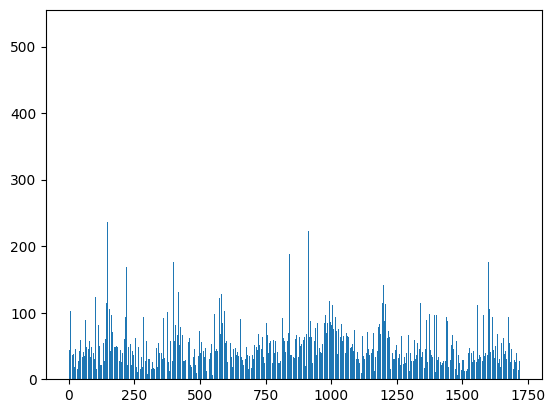

In [ ]:
y = [len(t.split()) for t in texts]
x = range(0, len(y))
plt.bar(x, y)

# Config

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM


class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 'jackaduma/SecBERT'
        self.NUM_LABELS = 14

        self.TOKENIZER = BertTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH = 320
        self.BATCH_SIZE = 16
        self.VALIDATION_SPLIT = 0.20

        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.N_VALIDATE_DUR_TRAIN = 3
        self.N_WARMUP = 0
        self.SAVE_BEST_ONLY = True
        self.EPOCHS = 15

config = Config()

## Dataset & Dataloader

In [ ]:
class TransformerDataset(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = config.TOKENIZER
        self.max_length = config.MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze()
        attention_mask = tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'input_ids': input_ids.long(),
                'attention_mask': attention_mask.long(),
                'labels': torch.Tensor(self.labels[index]).float(),
            }

        return {
            'input_ids': input_ids.long(),
            'attention_mask': attention_mask.long(),
        }

## Train-val Split


In [ ]:
df_train = pd.read_csv(project_dir + 'train_data.csv')
print(df_train.shape)
df_train.head()

(1387, 16)


,ID,Text,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,CVE-2020-15100,"In freewvs before 0.1.1, a user could create a...",0,0,1,0,1,0,0,0,0,0,0,0,0,1
1,CVE-2017-0262,"Microsoft Office 2010 SP2, Office 2013 SP1, an...",0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,CVE-2021-33709,A vulnerability has been identified in Teamcen...,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,CVE-2021-3393,An information leak was discovered in postgres...,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,CVE-2022-26850,When creating or updating credentials for sing...,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
df_test = pd.read_csv(project_dir + 'test_data.csv')
print(df_test.shape)
df_test.head()

(331, 16)


,ID,Text,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,CVE-2021-34803,TeamViewer before 14.7.48644 on Windows loads ...,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,CVE-2016-0034,Microsoft Silverlight 5 before 5.1.41212.0 mis...,0,0,1,1,0,0,0,0,0,0,0,0,0,1
2,CVE-2015-5123,Use-after-free vulnerability in the BitmapData...,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,CVE-2021-23964,Mozilla developers reported memory safety bugs...,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,CVE-2020-5812,Nessus AMI versions 8.12.0 and earlier were fo...,0,0,1,0,0,0,0,1,0,0,1,0,0,0


In [ ]:
train_data = TransformerDataset(df_train,  range(len(df_train)))
val_data = TransformerDataset(df_test, range(len(df_test)))

train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)

b = next(iter(train_dataloader))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

input_ids shape: torch.Size([16, 320])
attention_mask shape: torch.Size([16, 320])
labels shape: torch.Size([16, 14])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Model

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.transformer_model = AutoModel.from_pretrained(
            config.MODEL_PATH
        )
        self.dropout = nn.Dropout(0.3)

        self.output = nn.Linear(768, config.NUM_LABELS)

    def forward(
        self,
        input_ids,
        attention_mask=None,
        token_type_ids=None
        ):

        _, o2 = self.transformer_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )

        x = self.dropout(o2)
        out = self.output(x)

        return out

In [ ]:
device = config.DEVICE
device

device(type='cuda')

# Train and test



In [ ]:
def compute_metrics(predicted_y, true_y, metric_function, columns, limit):
  results = pd.DataFrame(columns = columns)
  if (metric_function == accuracy_score):
    results.loc[len(results)] = metric_function(true_y, predicted_y)
  else:
    results.loc[len(results)] = metric_function(true_y, predicted_y, average=None)

  sorted_results = results.sort_values(by=0, axis=1, ascending=False)

  print("Sorted results")
  sorted_results.head()
  return sorted_results.iloc[:, :limit]


def print_F1_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = f1_score(y_true, y_pred, average=None)

  Y_count = Y.apply(np.sum, axis=0)
  Y_count_sorted = Y_count.sort_values(ascending=False)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Tactics")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("F1 Score")

  ax = plt.gca()
  plt.show()

In [ ]:
BEST_F1 = 0
BEST_TRUE = []
BEST_PREDICTED = []

def val(model, val_dataloader, criterion):
    global BEST_F1, BEST_TRUE, BEST_PREDICTED

    val_loss = 0
    true, pred = [], []

    model.eval()

    for step, batch in enumerate(val_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

            loss = criterion(logits, b_labels)
            val_loss += loss.item()

            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()

            pred.extend(logits)
            true.extend(labels)

    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true, pred))

    print('Val precision:', precision_score(true, pred, average='weighted'))
    print('Val recall:', recall_score(true, pred, average='weighted'))

    val_micro_f1_score = f1_score(true, pred, average='micro')
    print('Val micro f1 score:', val_micro_f1_score)

    val_macro_f1_score = f1_score(true, pred, average='macro')
    print('Val macro f1 score:', val_macro_f1_score)

    val_weighted_f1_score = f1_score(true, pred, average='weighted')
    print('Val weighted f1 score:', val_weighted_f1_score)

    if (val_weighted_f1_score > BEST_F1):
      BEST_F1 = val_weighted_f1_score
      BEST_TRUE = true
      BEST_PREDICTED = pred

    return val_weighted_f1_score


def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch):
    nv = config.N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]

    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader,
                                      desc='Epoch ' + str(epoch))):
        model.train()

        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

        loss = criterion(logits, b_labels)
        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)

    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

# Run

In [ ]:
def run():
    torch.manual_seed(config.SEED)

    criterion = nn.BCEWithLogitsLoss()

    if config.FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

    num_training_steps = len(train_dataloader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    max_val_weighted_f1_score = float('-inf')
    for epoch in range(config.EPOCHS):
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_weighted_f1_score = val(model, val_dataloader, criterion)

        if config.SAVE_BEST_ONLY:
            if val_weighted_f1_score > max_val_weighted_f1_score:
                best_model = copy.deepcopy(model)

                model_name = 'secbert_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val: {max_val_weighted_f1_score} -> {val_weighted_f1_score}')
                max_val_weighted_f1_score = val_weighted_f1_score

    return best_model, max_val_weighted_f1_score

In [ ]:
model = Model()
model.to(device);

In [ ]:
best_model, best_val_weighted_f1_score = run()

Epoch 0:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.6548049904051281
Val accuracy: 0.0
Val precision: 0.2565387202703995
Val recall: 0.37320574162679426
Val micro f1 score: 0.2518837459634015
Val macro f1 score: 0.14055505102902424
Val weighted f1 score: 0.28711912420036206


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.3548271954059601
Val loss: 0.3067522992690404
Val accuracy: 0.012084592145015106
Val precision: 0.4082934609250399
Val recall: 0.014354066985645933
Val micro f1 score: 0.0282574568288854
Val macro f1 score: 0.008577074240548934
Val weighted f1 score: 0.027182327995921487


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: -inf -> 0.027182327995921487


Epoch 1:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.30612585516203017
Val accuracy: 0.015105740181268883
Val precision: 0.34279638490164804
Val recall: 0.017543859649122806
Val micro f1 score: 0.034375
Val macro f1 score: 0.01052981914486822
Val weighted f1 score: 0.03307745738075553


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.286577558894267
Val loss: 0.2729631470782416
Val accuracy: 0.1782477341389728
Val precision: 0.6341217976043159
Val recall: 0.2727272727272727
Val micro f1 score: 0.4018801410105758
Val macro f1 score: 0.16089939985432128
Val weighted f1 score: 0.3528042109627489


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: 0.027182327995921487 -> 0.3528042109627489


Epoch 2:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.27301344914095743
Val accuracy: 0.18429003021148035
Val precision: 0.63509005899134
Val recall: 0.2807017543859649
Val micro f1 score: 0.41025641025641024
Val macro f1 score: 0.16615738384212095
Val weighted f1 score: 0.36167830709918014


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.24499338471341406
Val loss: 0.2658169801746096
Val accuracy: 0.21450151057401812
Val precision: 0.6356583387591402
Val recall: 0.39074960127591707
Val micro f1 score: 0.5030800821355236
Val macro f1 score: 0.23518545679956246
Val weighted f1 score: 0.46466171583964977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: 0.3528042109627489 -> 0.46466171583964977


Epoch 3:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.2665786963133585
Val accuracy: 0.21148036253776434
Val precision: 0.612982914943094
Val recall: 0.39553429027113235
Val micro f1 score: 0.5040650406504065
Val macro f1 score: 0.23693893521943585
Val weighted f1 score: 0.4673027404323845


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.20451385210985426
Val loss: 0.2690941499812262
Val accuracy: 0.229607250755287
Val precision: 0.6088436157204483
Val recall: 0.43381180223285487
Val micro f1 score: 0.5317693059628543
Val macro f1 score: 0.25941185518606047
Val weighted f1 score: 0.49733295623562773


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: 0.46466171583964977 -> 0.49733295623562773


Epoch 4:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.2709424765337081
Val accuracy: 0.22658610271903323
Val precision: 0.6101021531424028
Val recall: 0.42902711323763953
Val micro f1 score: 0.5279685966633954
Val macro f1 score: 0.25885021984458917
Val weighted f1 score: 0.4943565505831594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.16368316328045965
Val loss: 0.28159147571949733
Val accuracy: 0.22356495468277945
Val precision: 0.5721656213884166
Val recall: 0.44178628389154706
Val micro f1 score: 0.5246212121212122
Val macro f1 score: 0.2519687581390657
Val weighted f1 score: 0.49002110532701915


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.28014788599241347
Val accuracy: 0.21148036253776434
Val precision: 0.5622427797392111
Val recall: 0.4274322169059011
Val micro f1 score: 0.5129186602870813
Val macro f1 score: 0.2474870768746938
Val weighted f1 score: 0.4797831087213152


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.1334979260104826
Val loss: 0.29908020936307456
Val accuracy: 0.2537764350453172
Val precision: 0.5695776206665781
Val recall: 0.5279106858054227
Val micro f1 score: 0.5711820534943917
Val macro f1 score: 0.2916601573114174
Val weighted f1 score: 0.5391735380578169


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: 0.49733295623562773 -> 0.5391735380578169


Epoch 6:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.2963050454854965
Val accuracy: 0.24773413897280966
Val precision: 0.5663646570335897
Val recall: 0.518341307814992
Val micro f1 score: 0.5652173913043479
Val macro f1 score: 0.2904787185805082
Val weighted f1 score: 0.5316301569643197


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.11469517142950804
Val loss: 0.3037718903450739
Val accuracy: 0.2326283987915408
Val precision: 0.5724341437177802
Val recall: 0.48325358851674644
Val micro f1 score: 0.5420393559928444
Val macro f1 score: 0.28760250805208437
Val weighted f1 score: 0.5202759903851917


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.3061472801935105
Val accuracy: 0.22356495468277945
Val precision: 0.5702734454501245
Val recall: 0.507177033492823
Val micro f1 score: 0.5564304461942258
Val macro f1 score: 0.290664896227326
Val weighted f1 score: 0.5319035007599423


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.09875978422404706
Val loss: 0.3128290580851691
Val accuracy: 0.18731117824773413
Val precision: 0.5985554892140432
Val recall: 0.3827751196172249
Val micro f1 score: 0.4752475247524753
Val macro f1 score: 0.2513761242447154
Val weighted f1 score: 0.4561104324571081


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.3109325362103326
Val accuracy: 0.2054380664652568
Val precision: 0.6031397210107952
Val recall: 0.40669856459330145
Val micro f1 score: 0.4932301740812379
Val macro f1 score: 0.2611997169464233
Val weighted f1 score: 0.4755603720931087


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.08647674527661554
Val loss: 0.31739863753318787
Val accuracy: 0.1691842900302115
Val precision: 0.6068921500430531
Val recall: 0.3524720893141946
Val micro f1 score: 0.46185997910135845
Val macro f1 score: 0.2486249898261816
Val weighted f1 score: 0.4398333902286465


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.3172349468583152
Val accuracy: 0.1691842900302115
Val precision: 0.598589746094131
Val recall: 0.35566188197767146
Val micro f1 score: 0.46217616580310883
Val macro f1 score: 0.2486715893367231
Val weighted f1 score: 0.44131919051114127


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.07582300263403476
Val loss: 0.31486048868724276
Val accuracy: 0.1782477341389728
Val precision: 0.610322395170573
Val recall: 0.38915470494417864
Val micro f1 score: 0.4884884884884885
Val macro f1 score: 0.2756707566979237
Val weighted f1 score: 0.46591679304734207


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.3151436909323647
Val accuracy: 0.18429003021148035
Val precision: 0.616593664389541
Val recall: 0.3939393939393939
Val micro f1 score: 0.49301397205588826
Val macro f1 score: 0.2812529749134977
Val weighted f1 score: 0.4720008966466868


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.06742553622729477
Val loss: 0.31561744638851713
Val accuracy: 0.2054380664652568
Val precision: 0.6193955445510253
Val recall: 0.41148325358851673
Val micro f1 score: 0.5073746312684365
Val macro f1 score: 0.2857526235662965
Val weighted f1 score: 0.4849026435319252


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.3164760165271305
Val accuracy: 0.19637462235649547
Val precision: 0.6185802833503462
Val recall: 0.4082934609250399
Val micro f1 score: 0.5044334975369458
Val macro f1 score: 0.28555620395408765
Val weighted f1 score: 0.48288509866948287


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.061975297742876516
Val loss: 0.31675736748036887
Val accuracy: 0.1933534743202417
Val precision: 0.6067977636398689
Val recall: 0.41626794258373206
Val micro f1 score: 0.5077821011673151
Val macro f1 score: 0.2842191184295752
Val weighted f1 score: 0.4854974890344484


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.31711540406658534
Val accuracy: 0.19637462235649547
Val precision: 0.618419647021907
Val recall: 0.4178628389154705
Val micro f1 score: 0.511219512195122
Val macro f1 score: 0.28960887151635084
Val weighted f1 score: 0.49002158894058384


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.05806418671005074
Val loss: 0.3175755732116245
Val accuracy: 0.2084592145015106
Val precision: 0.6207360846626189
Val recall: 0.4258373205741627
Val micro f1 score: 0.5169409486931268
Val macro f1 score: 0.295152630326079
Val weighted f1 score: 0.49460253790823533


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.3178174275727499
Val accuracy: 0.2054380664652568
Val precision: 0.6230259005592603
Val recall: 0.4226475279106858
Val micro f1 score: 0.5150631681243926
Val macro f1 score: 0.2944572820132615
Val weighted f1 score: 0.4932834921234776


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.054952264602842
Val loss: 0.31828661333946956
Val accuracy: 0.2175226586102719
Val precision: 0.6186801760487921
Val recall: 0.43859649122807015
Val micro f1 score: 0.5258126195028681
Val macro f1 score: 0.2967637805323236
Val weighted f1 score: 0.5000806631631652


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.31826533164296833
Val accuracy: 0.2175226586102719
Val precision: 0.6210395360723857
Val recall: 0.43859649122807015
Val micro f1 score: 0.5268199233716475
Val macro f1 score: 0.2971099948608592
Val weighted f1 score: 0.5011938499037197


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.053536008700899695
Val loss: 0.31871263186136883
Val accuracy: 0.21148036253776434
Val precision: 0.6074743650365533
Val recall: 0.44178628389154706
Val micro f1 score: 0.5236294896030246
Val macro f1 score: 0.2973784163878275
Val weighted f1 score: 0.5014046148133711


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(BEST_F1)

0.5391735380578169


In [ ]:
y_train_df = df_train.drop(df_train.columns[0:2], axis=1)

In [ ]:
f1_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, f1_score, df_test.columns[2:], 14)

Sorted results


In [ ]:
print(f1_best_metrics)

     Impact  Execution  Initial Access  Collection  Credential Access  \
0  0.731034    0.69863        0.632302    0.541667           0.478873   

   Privilege Escalation  Persistence  Discovery  Reconnaissance  \
0                 0.432     0.358209   0.210526             0.0   

   Resource Development  Defense Evasion  Lateral Movement  \
0                   0.0              0.0               0.0   

   Command and Control  Exfiltration  
0                  0.0           0.0  


In [ ]:
f1_best_metrics.head()

,Impact,Execution,Initial Access,Collection,Credential Access,Privilege Escalation,Persistence,Discovery,Reconnaissance,Resource Development,Defense Evasion,Lateral Movement,Command and Control,Exfiltration
0,0.731034,0.69863,0.632302,0.541667,0.478873,0.432,0.358209,0.210526,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics import (
    recall_score,
    precision_score
  )

In [ ]:
recall_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, recall_score, df_test.columns[2:], 14)
recall_best_metrics.head()

Sorted results


,Initial Access,Execution,Impact,Collection,Privilege Escalation,Credential Access,Persistence,Discovery,Reconnaissance,Resource Development,Defense Evasion,Lateral Movement,Command and Control,Exfiltration
0,0.71875,0.708333,0.6625,0.490566,0.375,0.369565,0.324324,0.142857,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
precision_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, precision_score, df_test.columns[2:], 14)
precision_best_metrics.head()

Sorted results


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Impact,Execution,Credential Access,Collection,Initial Access,Privilege Escalation,Persistence,Discovery,Reconnaissance,Resource Development,Defense Evasion,Lateral Movement,Command and Control,Exfiltration
0,0.815385,0.689189,0.68,0.604651,0.564417,0.509434,0.4,0.4,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
acc_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, accuracy_score, df_test.columns[2:], 14)
acc_best_metrics.head()

Sorted results


,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,0.253776,0.253776,0.253776,0.253776,0.253776,0.253776,0.253776,0.253776,0.253776,0.253776,0.253776,0.253776,0.253776,0.253776


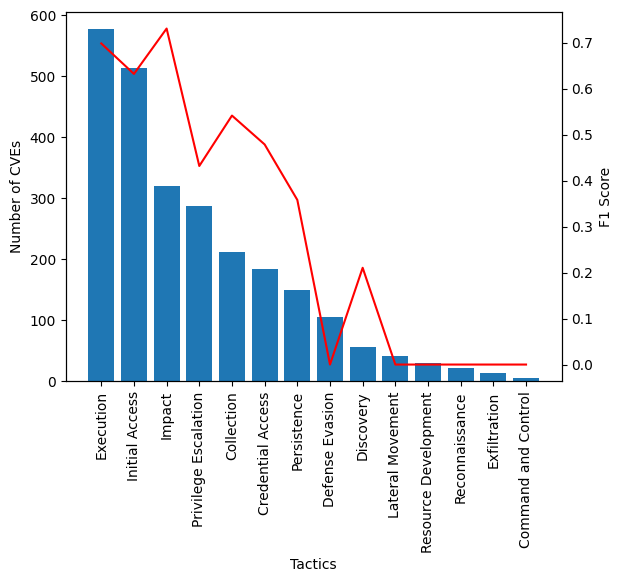

In [ ]:
print_F1_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  df_test.columns[2:])